# **Diogo Barroso Dias PG42825**
# **Nelson Filipe Sá Costa PG44587**

# **Bibliotecas**

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
np.set_printoptions(precision=4)
from sklearn.metrics import accuracy_score, recall_score, precision_score , confusion_matrix
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# **Gráficos a ser usados**

In [ ]:
def plot_bar(column, sort=False, title="all"):
    if sort:
        data_all = cd[column].value_counts().sort_index()
    else:
        data_all = cd[column].value_counts()
    plt.bar(data_all.index,data_all)
    plt.title(title)
    plt.show()

def plot_pie(column, title="All"):
    fig,axs = plt.subplots(1,1)
    data = cd[column].value_counts()
    plt.pie(data,autopct='%1.2f%%',labels=data.index)
    plt.title(title)
    plt.show()

def plot_hist(column, title="all"):
    plt.hist(cd[column],density=True)
    plt.title(title)
    plt.show()


# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


# **Análise de Dados - $ Dataset$ $Chess$ $Game $**

**Carregamento dos dados**

In [94]:
cd = pd.read_csv("./games.csv")

# Análise Exploratória de Dados


**Informação Básica**

Size of Array and number of columns

In [ ]:
cd.shape

(20058, 16)

Excerto de valores do dataset

In [ ]:
cd.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5




*   **id**: identificação da partida
*   **rated**: identifica se a partida conta para o rating
*   **created_at**: quando o jogo começou
*   **last_move_at**: quando o jogo acabou
*   **turns**: número de turnos que a partida teve
*   **victory_status**: tipo de resultado da partida (empate, check mate, desistiu)
*   **winner**: indica o vencedor, ou se não houve, o empate
*   **increment_code**: número de segundos que são adicionados ao tempo depois de uma jogada

*   **white_id**: identificação do jogador das peças brancas

*   **white_rating**: classificação do jogador das peças brancas

*   **black_id**: identificação do jogador das peças pretas
*   **black_rating**: classificação do jogador das peças pretas


*   **moves**: todas as jogadas em notação de xadrex


*   **opening_eco**: código que representa uma opening (movimento de abertura) em xadrex ([lista de todas as openings)](https://www.365chess.com/eco.php)


*   **opening_name**: nome do movimento de abertura
*   **opening_ply**: número de jogadas na fase de opening





Verificar se existem *Missing Values* em cada coluna

(Se um atributo está 100% populado, não existem missing values)



In [95]:
cd = cd.replace(r'^\s*$', np.NaN, regex=True)

print("Verifica o quanto populados as colunas estão:")
total_rows = len(cd)
for column in cd.columns:
    missing_values = cd[column].isnull().sum()
    print(column, "está populado: ", (total_rows - missing_values) / total_rows * 100, "%")

Verifica o quanto populados as colunas estão:
id está populado:  100.0 %
rated está populado:  100.0 %
created_at está populado:  100.0 %
last_move_at está populado:  100.0 %
turns está populado:  100.0 %
victory_status está populado:  100.0 %
winner está populado:  100.0 %
increment_code está populado:  100.0 %
white_id está populado:  100.0 %
white_rating está populado:  100.0 %
black_id está populado:  100.0 %
black_rating está populado:  100.0 %
moves está populado:  100.0 %
opening_eco está populado:  100.0 %
opening_name está populado:  100.0 %
opening_ply está populado:  100.0 %


Indica o número de jogos com o id duplicado



In [96]:
dupe = cd.duplicated(subset=['id'])
sum(dupe)

945

Remove os jogos duplicados pelo id

In [97]:
cd = cd.drop_duplicates(subset=['id'])

Verifica a *uniqueness* das features

In [98]:
for column in cd.columns:
      if cd[column].is_unique:
          print(column, "is unique: 100%")
      else:
          comp1 = len(cd[column]) # número de linhas
          comp2 = len(cd[column].drop_duplicates(keep=False))
          print(column, "is unique: ", comp2/comp1 * 100, "%")

id is unique: 100%
rated is unique:  0.0 %
created_at is unique:  56.908910165855694 %
last_move_at is unique:  57.21760058598859 %
turns is unique:  0.1046408203840318 %
victory_status is unique:  0.0 %
winner is unique:  0.0 %
increment_code is unique:  0.5075079788625543 %
white_id is unique:  39.41296499764558 %
white_rating is unique:  0.7900381938994401 %
black_id is unique:  39.04149008528227 %
black_rating is unique:  0.8475906451106577 %
moves is unique:  98.72861403233402 %
opening_eco is unique:  0.26683409197928115 %
opening_name is unique:  2.0666562025846282 %
opening_ply is unique:  0.010464082038403181 %


Informações a retirar:

*   39% dos jogadores só jogaram uma vez de peças brancas ou só uma vez de peças pretas.
*   98% das jogadas ('moves') foram únicas, ou seja, em 2% dos jogos há partidas que tiveram moves iguais a outros.

*   2% de Movimentos de Abertura ('opening_name') são únicos, só foram jogados uma vez no historial de 20k jogos.




**Estatísticas dos dados**

In [ ]:
cd.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,1.911300e+04,1.911300e+04,19113.000000,19113.000000,19113.000000,19113.000000
mean,1.483413e+12,1.483414e+12,60.513839,1597.300005,1590.045519,4.815780
std,2.833975e+10,2.833964e+10,33.488264,290.022740,290.441694,2.798283
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.476910e+12,1.476912e+12,37.000000,1401.000000,1394.000000,3.000000
50%,1.495670e+12,1.495670e+12,55.000000,1567.000000,1563.000000,4.000000
75%,1.503080e+12,1.503080e+12,79.000000,1792.000000,1785.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


*Descrição estatística da variável* ***turns***

São consideradas partidas com poucas jogadas, aquelas que têm menos de 37 turnos

A maior parte das partidas tem entre 37 a 79 turnos

A partir de 79 para cima já são partidas com uma quantidade de turnos maior que a média

*Descrição estatística das variáveis* ***rating***

Como é possível verificar pelos valores, as estatísticas de white_rating e black_rating são muito semelhantes. Assim conseguimos tirar as seguintes conclusões:

**Classificação Baixa**: Rating menor que 1401

**Classificação Mais Frequente**: Entre 1401 e 1792

**Classificação Alta**: Maior que 1792



**Quantidade exata de jogos ranked/competitivos e casuais**

**true**: ranked

**false**: casual

In [ ]:
cd['rated'].value_counts()

True     15467
False     3646
Name: rated, dtype: int64

**Quantidade exata de vitórias ou empates**

In [ ]:
cd['winner'].value_counts()

white    9545
black    8680
draw      888
Name: winner, dtype: int64

**Os 10 jogadores que jogaram mais vezes com as peças brancas**

In [ ]:
cd['white_id'].value_counts().head(10)

ssf7             48
bleda            48
hassan1365416    44
khelil           41
1240100948       38
ozguragarr       38
ivanbus          36
vovkakuz         35
islam01          31
ozil17           30
Name: white_id, dtype: int64

**Os 10 jogadores que jogaram mais vezes com as peças pretas**

In [ ]:
cd['black_id'].value_counts().head(10)

docboss               44
cape217               38
amanan                33
erikweisz             31
vladimir-kramnik-1    30
jdbarger              30
blazingdragon         29
pat222                29
dipset                29
andreas00             29
Name: black_id, dtype: int64

**Os códigos dos 10 movimentos de abertura mais usados**

In [ ]:
cd['opening_eco'].value_counts().head(10)

A00    948
C00    810
D00    701
B01    688
C41    650
C20    646
A40    606
B00    574
B20    551
C50    500
Name: opening_eco, dtype: int64

**O nome dos 10 movimentos de abertura mais usados**

In [ ]:
cd['opening_name'].value_counts().head(10)

Sicilian Defense                                 349
Van't Kruijs Opening                             342
Sicilian Defense: Bowdler Attack                 290
French Defense: Knight Variation                 260
Scotch Game                                      254
Scandinavian Defense: Mieses-Kotroc Variation    247
Queen's Pawn Game: Mason Attack                  227
Queen's Pawn Game: Chigorin Variation            217
Scandinavian Defense                             217
Horwitz Defense                                  208
Name: opening_name, dtype: int64

# **Exploração Gráfica dos dados**

**Percentagem de jogos ranked e casuais**

Jogos competitivos (true) e jogos casuais (false)

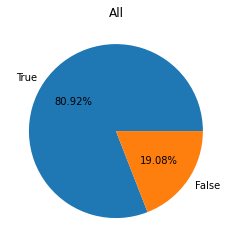

In [ ]:
plot_pie('rated')

**Frequência dos Turnos**

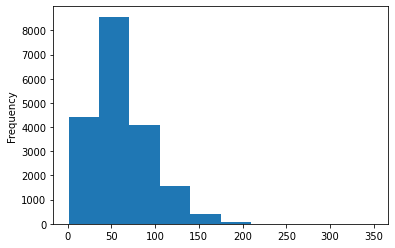

In [ ]:
cd['turns'].plot(kind='hist')

**Frequência de cada tipo de resultado de uma partida**

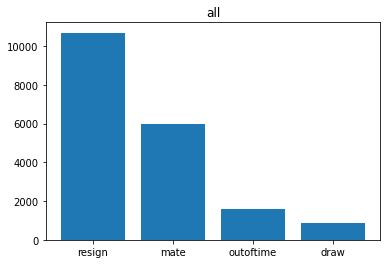

In [ ]:
plot_bar('victory_status')

**Percentagem de cada tipo de resultado de uma partida**

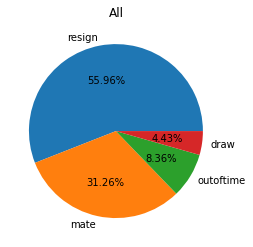

In [ ]:
plot_pie('victory_status')

**Frequência de vitórias de cada peça, ou então se for o caso de empate**

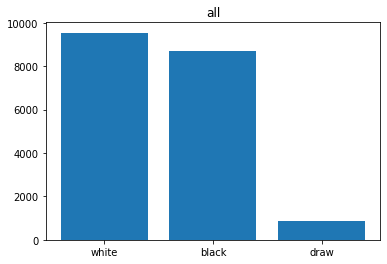

In [ ]:
plot_bar('winner')

**Percentagem de vitórias de cada peça, ou então se for o caso de empate**

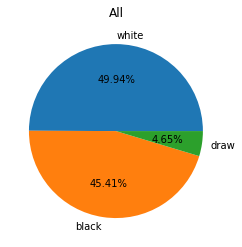

In [ ]:
plot_pie('winner')

**Frequência de white_rating**

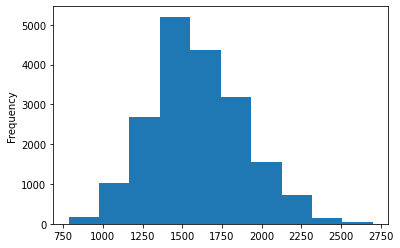

In [ ]:
cd['white_rating'].plot(kind='hist')

**Frequência de black_rating**

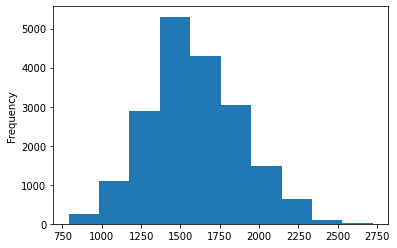

In [ ]:
cd['black_rating'].plot(kind='hist')

**Frequência do número de jogadas num movimento de abertura de uma partida**

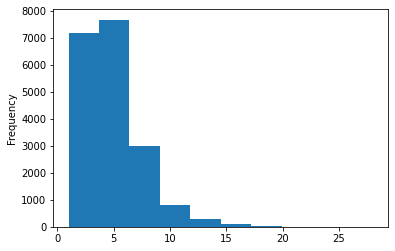

In [ ]:
cd['opening_ply'].plot(kind='hist')

Exemplo de função para criar vários histogramas


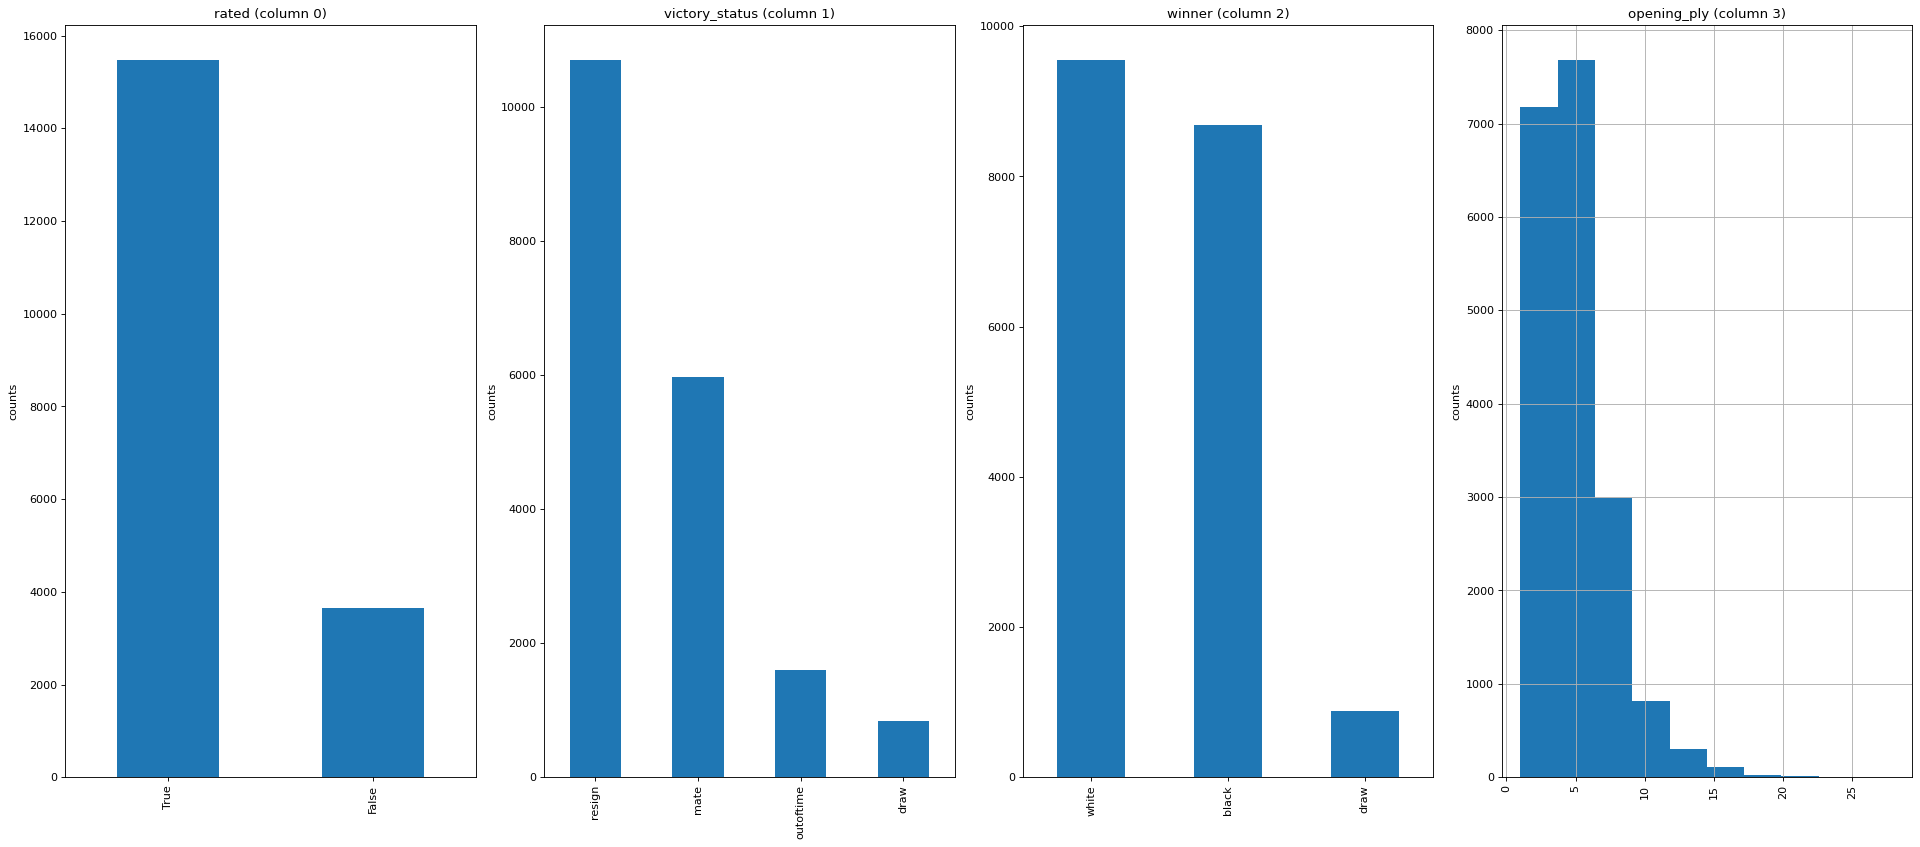

In [ ]:
plotPerColumnDistribution(cd, 10, 9)

**Matriz de Correlação**

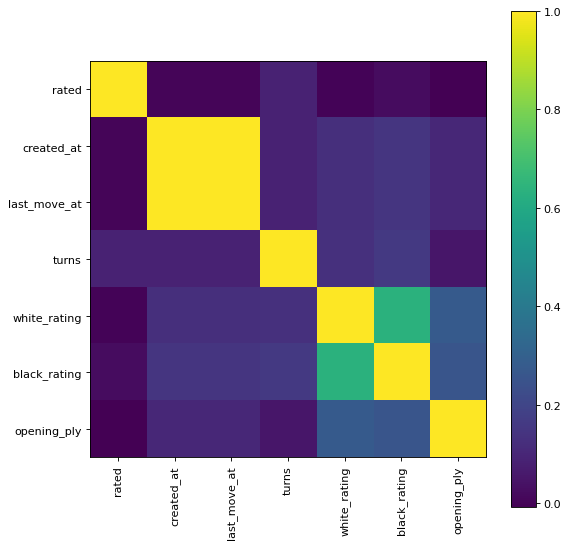

In [ ]:
plotCorrelationMatrix(cd, 8)

Como é possível analisar: 

*   **created_at** e **last_move_at** apresentam o grau de correlação máximo.
*   **white_rating** e **black_rating** têm correlação elevada, o que faz sentido, o jogo prioriza dar matchup de jogadores com rating semelhante
*   **opening_ply** tem um bocado de correlação com os ratings




# **Pré-Processamento**

Remove-se os dados com que não vamos trabalhar.

O objetivo do trabalho é prever quem é o vencedor de uma partida de xadrex, ou então se a partida resultou em empate, através dos movimentos que os jogadores realizam ao longo do jogo.

Removeu-se as seguintes features com o objetivo de desenvolver o melhor modelo de machine learning:

*   **id**: Não tem nenhum impacto na partida
*   **rated**: Em príncipio não tem nenhum impacto na partida
*   **created_at** & **last_move_at**: Não tem nenhum impacto na partida
*   **turns**: Produz um modelo que é contra produtivo aos nossos objetivos, pois pelo número de turnos torna-se bastante fácil prever o resultado, visto que numa partida começa sempre o jogador das peças brancas. Por exemplo, numa partida que acabou em xeque-mate, se o número de turnos for ímpar, 13 por exemplo, foi o jogador das peças brancas o último a jogar, portanto presume-se que haja uma maior probabilidade de ter sido ele a ganhar. Se for um número par de turnos foi o jogador das peças pretas o último a jogar e é ele o presumido winner.
*   **victory_status** & **increment code**: Não nos ajuda a descobrir quem é o vencedor
*   **white_id** & **black_id**: Não nos interessa saber quem é o jogador
*   **moves**: Em príncipio, pelo mesmo raciocínio que levou a retirar a feature 'turns', também não vai ajudar no modelo, mas também porque no formato em que está é difícil aprender algo com os dados. É preciso estudar alguma forma de restruturar os dados para os melhor podermos usar na aprendizagem supervisionada. 










In [ ]:
X = cd.copy()

y = X['winner']

#Drop the Attrition_Flag Column
X = X.drop(['winner',"id",'rated','created_at', 'last_move_at', 'turns','victory_status','increment_code','white_id','black_id','moves'], axis=1)
X.columns

Copiamos a coluna 'winner' para uma varíavel *y* e de seguida realizamos uma operação de label enconding, que passa os valores de um tipo de variável categórica para um valor númerico. Assim conseguimos usar essa varíavel como target do modelo de ML.

In [119]:
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.DataFrame({'winner': y})

Converte-se as features do tipo categório para variáveis fictícias (dummy variable) que indica a presença ou ausência de algum efeito categórico que possa ter impacto na feature 'winner'.

In [ ]:
X = pd.get_dummies(X, columns=['opening_eco','opening_name'],drop_first=True)

### **Dividir o dataset em dados de treino e de teste**


In [242]:
from sklearn import preprocessing
X_input = preprocessing.scale(X)

In [244]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_input, y, test_size= 0.2, random_state=1234)

Como observado no resultado abaixo a varíavel de predição, 'winner', apresenta uma má representação das classes existentes, com o caso extremo do empate a representar só 4.59% dos dados

In [ ]:
np.unique(y_train, return_counts=True)
unique_values, abs_freqs = np.unique(y_train, return_counts=True)
relative_freqs = abs_freqs/(sum(abs_freqs)) * 100
print (relative_freqs)

In [ ]:
y_train.value_counts()

Divisão do dataset de forma equitativa de classes da variável de interesse *winner*.

Com recurso à técnica de oversampling *SMOTE* populamos os dados em minoria para não correr o risco de darmos overfitting dos dados com o uso de random oversampling.

Aplicada a técnica, verifica-se que cada classe apresenta-se nos dados de treino e de teste na mesma quantidade de vezes 

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1234)

X_smote, y_smote = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_smote.shape}''')

print('\nBalance of positive and negative classes (%):')
np.unique(y_smote, return_counts=True)
unique_values, abs_freqs = np.unique(y_smote, return_counts=True)
relative_freqs = abs_freqs/(sum(abs_freqs)) * 100
print (relative_freqs)

# **Construção de Modelos**

**Biblioteca dos modelos de aprendizagem de machine learning**

In [40]:
# Import ML Libraries
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

classifiers = [[RandomForestClassifier(),'Random Forest'], 
    [KNeighborsClassifier(), 'K-Nearest Neighbours'], [SGDClassifier(),'SGD Classifier'], [SVC(),'SVC'],
              [GaussianNB(),'GaussianNB'],[DecisionTreeClassifier(),'Decision Tree Classifier'],[LogisticRegression(),'Logistic Regression']]

Previsão de classes para o target *winner* utilizando os modelos acima declarados



In [ ]:
def predict(X_smote, y_smote,X_test,y_test):
    for cls in classifiers:
        model = cls[0]
        model.fit(X_smote, y_smote)

        y_pred = model.predict(X_test)
        print(cls[1])
        print ('Confusion Matrix:')
        print(confusion_matrix(y_test, y_pred))
        print("Accuracy : ", accuracy_score(y_test, y_pred) *  100)

Apresentação da Matriz de Confusão, e da métrica de *Accuracy*

In [ ]:
predict(X_smote, y_smote,X_test,y_test)

#Construção de Modelos II

Treinar modelos de base com vários classificadores no conjunto de dados de treino. Avaliar cada um destes modelos com validação cruzada.

In [127]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import learning_curve

##K-Neighbors

In [ ]:
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

pecc_knn = cross_val_score(knn_model, X_train, y_train, cv = 5).mean()
pecc_knn

## Support Vector Machine

In [ ]:
from sklearn import svm

svm_model = svm.SVC(gamma=0.001, C=10.)

pecc_svm = cross_val_score(svm_model, X_train, y_train, cv = 5).mean()
pecc_svm

## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)

pecc_rf = cross_val_score(rf_model, X_train, y_train, cv = 5).mean()
pecc_rf

## Adaptive Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_tree = AdaBoostClassifier(n_estimators=100)

pecc_ada = cross_val_score(ada_tree, X_smote, y_smote, cv = 5).mean()
pecc_ada

##Seleção de Atributos (ANOVA)

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=50)
filt_univ = selector.fit_transform(X_train, y_train)
print(filt_univ.shape)

In [ ]:
cross_val_score(knn_model, filt_univ, y_train, cv = 5).mean()

0.4777633516337677

In [ ]:
cross_val_score(svm_model, filt_univ, y_train, cv = 5).mean()

0.48508858248466813

In [ ]:
cross_val_score(rf_model, filt_univ, y_train, cv = 5).mean()

0.582629534945448

In [ ]:
cross_val_score(ada_tree, filt_univ, y_train, cv = 5).mean()

0.6087895450037021

##Otimização de Hiperparâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

## K-Neighbors

In [ ]:
knn_parameters = {'n_neighbors':[3,5,11,19], 'weights':['uniform', 'distance'], 'metric':['euclidean', 'manhattan']}

knn_model_d = KNeighborsClassifier()
opt_knn_model_d = GridSearchCV(knn_model_d, knn_parameters, cv=5)

opt_knn_model_d.fit(X_train, y_train)
print (opt_knn_model_d.best_estimator_)

In [ ]:
pecc_opt_knn = cross_val_score(opt_knn_model_d, X_train, y_train, cv = 5).mean()
pecc_opt_knn

## SVM

In [ ]:
svm_parameters = {'C':[1, 10, 100], 'gamma':[0.01, 0.001]}

svm_model_d = svm.SVC()
opt_svm_model_d = GridSearchCV(svm_model_d, svm_parameters)

opt_svm_model_d.fit(X_train, y_train)
print (opt_svm_model_d.best_estimator_)

In [ ]:
pecc_opt_svm = cross_val_score(opt_svm_model_d, X_train, y_train, cv = 5).mean()
pecc_opt_svm

## Random Forest

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rf_model_d = RandomForestClassifier(random_state=1234)

opt_rf_model_d = GridSearchCV(rf_model_d, param_grid=param_grid, cv= 2)

opt_rf_model_d.fit(X_smote, y_smote)
print (opt_rf_model_d.best_estimator_)

In [ ]:
pecc_opt_rf = cross_val_score(opt_rf_model_d, X_smote, y_smote, cv = 2).mean()

In [ ]:
pecc_opt_rf

## AdaBoosting

In [ ]:
ada_model_d = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parameters = {
              'base_estimator__max_depth':[i for i in range(2,5,8)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

opt_ada_model_d = GridSearchCV(ada_model_d, parameters)
opt_ada_model_d.fit(X_smote, y_smote)
print (opt_ada_model_d.best_estimator_)

Parameters taken from:
(https://stackoverflow.com/questions/32210569/using-gridsearchcv-with-adaboost-and-decisiontreeclassifier)

In [17]:
opt_ada_model_acc = cross_val_score(opt_ada_model_d, X_smote, y_smote, cv = 2).mean()

In [ ]:
opt_ada_model_acc

## Implementação da Neural Network
https://machinelearningmastery.com/neural-network-models-for-combined-classification-and-regression/
(Classification Model)

In [133]:
# first neural network with keras tutorial
from keras.models import Sequential
from keras.layers import Dense

In [160]:
from numpy import unique
from numpy import argmax

In [215]:
model = Sequential()
model.add(Dense(100, input_dim=1843, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(3, activation='softmax'))

In [222]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_smote, y_smote, epochs=25, batch_size=150, verbose=2)

In [ ]:
yhat = model.predict(X_test)
yhat = argmax(yhat, axis=-1).astype('int')
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % acc)